# Tutorial for GNN Explainability

In this hand-on code tutorial, we will show how to apply our DIG xgraph APIs to explain a well-trained model. Specifically, we will demonstrate two methods **GNNExplainer** and **SubgraphX** on the node classification dataset BA-shapes.

## GNN explainability
Graph Neural Networks are usually treated as black-boxes and lacking explainability. Without reasoning the prediction procedures of GNNs, we do not understand GNN models and do not know whether the models work in our expected way, thus preventing their use in critical applications pertaining to fairness, privacy, and safety.

### Load the dataset BA-shapes

In [1]:
import os
import sys
import os.path as osp
sys.path.insert(0, os.sep.join(os.path.abspath('').split(os.sep)[:-2]))

import torch
from torch_geometric.data import download_url, extract_zip

from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
from dig.xgraph.utils.compatibility import compatible_state_dict
from dig.xgraph.utils.init import fix_random_seed

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fix_random_seed(123)
dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
dim_node = dataset.num_node_features
num_classes = dataset.num_classes

data = dataset[0]
target_node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()

/data/haiyang/anaconda3/envs/pyg2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the well-trained GCN model

In [2]:
def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)


model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)
check_checkpoints()
ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
state_dict = compatible_state_dict(torch.load(ckpt_path, map_location='cpu')['state_dict'])
model.load_state_dict(state_dict)

<All keys matched successfully>

### GNNExplainer

GNNExplainer learns soft masks for edges and node features to identify important input information. The masks are randomly initialized and updated to maximize the mutual information between original predictions and perturbed graphs.
Here we setup **GNNExplainer** and take it to explain the predictions for 20 target nodes.

In [3]:
from dig.xgraph.method import GNNExplainer
from dig.xgraph.evaluation import XCollector

gnnexplainer = GNNExplainer(model, epochs=100, lr=0.01, explain_graph=False)

### SubgraphX
SubgraphX explores subgraph-level explanations for graph neural networks. It employs the Monte Carlo Tree Search algorithm to efficiently explore different subgraphs via node pruning and select the most important subgraph as the explanation. The importance of subgraphs is measured by Shapley values.

In [4]:
from dig.xgraph.method import SubgraphX

subgraphx_explainer = SubgraphX(model,
                                num_classes=num_classes,
                                device=device,
                                explain_graph=False,
                                reward_method='nc_mc_l_shapley')

## Visualization
We provide the visualization APIs for Synthetic, Text2Graph and Molecules datasets to provide human-intelligible explanation visualizations.

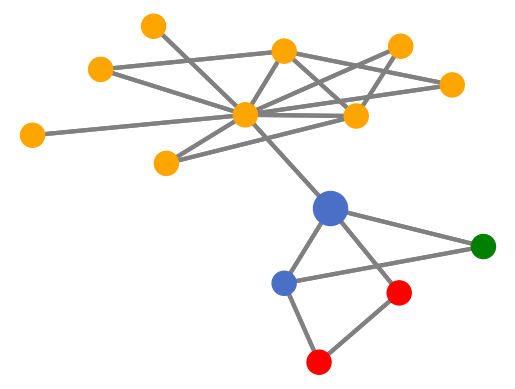

In [5]:
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops

data = dataset[0].to(device)
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
node_idx = node_indices[20]

subgraph_x, subgraph_edge_index, subset, edge_mask, kwargs = \
    MCTS.__subgraph__(node_idx, data.x, data.edge_index, num_hops=2)
new_node_idx = torch.argwhere(subset == node_idx)[0]

subgraph_y = data.y[subset].to('cpu')
vis_graph = to_networkx(Data(x=subgraph_x, edge_index=subgraph_edge_index))
plotutils = PlotUtils(dataset_name='ba_shapes')
plotutils.plot(vis_graph, nodelist=[], figname=None, y=subgraph_y, node_idx=new_node_idx)

### Visualization results for the GNNExplainer

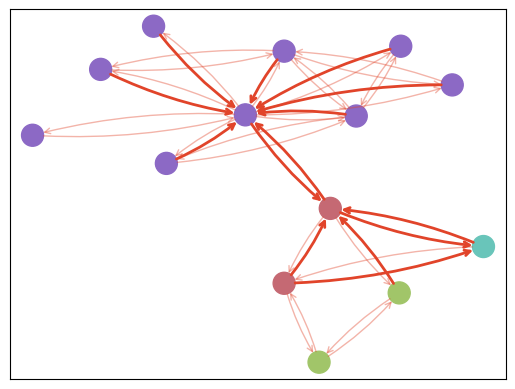

In [12]:
sparsity = 0.7
import matplotlib.pyplot as plt

# Visualization
gnnexplainer_related_preds = \
    gnnexplainer(data.x, data.edge_index, sparsity=sparsity, num_classes=num_classes, node_idx=node_idx)
ax, G = gnnexplainer.visualize_graph(node_idx=node_idx, 
                                     edge_index=data.edge_index, 
                                     edge_mask=gnnexplainer_related_preds[1][prediction], 
                                     y=data.y)
plt.show()

### Visualization results for the SubgraphX

explain graph node 515


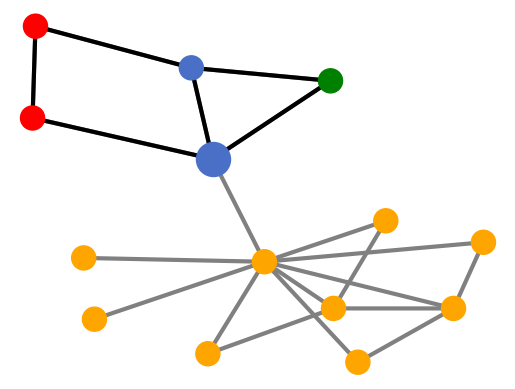

In [14]:
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import find_closest_node_result

# Visualization
max_nodes = 5
node_idx = node_indices[20]
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

_, explanation_results, related_preds = \
    subgraphx_explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

explanation_results = explanation_results[prediction]
explanation_results = subgraphx_explainer.read_from_MCTSInfo_list(explanation_results)

plotutils = PlotUtils(dataset_name='ba_shapes', is_show=True)
subgraphx_explainer.visualization(explanation_results,
                        max_nodes=max_nodes,
                        plot_utils=plotutils,
                        y=data.y)

### Metric
Here we apply two metric Fidelity and Sparsity to compare these two explainability methods.
Fidelity is the probability difference between the original prediction and new prediction when masking the important explanation results. In addition, Sparsity is the ratio of the number of edges not in the final explanation of edges.

 Next, we take GNNExplainer and SubgraphX to explain the same model predictions. Here we control similar sparsity scores and compare the fidelity score.

In [15]:
sparsity = 0.15
gnnexplainer_collector = XCollector()

max_nodes = 5
subgraphx_collector = XCollector()

for data_idx, node_idx in enumerate(target_node_indices[:20]):
    data.to(device)

    logits = model(data.x, data.edge_index)
    prediction = logits[node_idx].argmax(-1).item()

    gnnexplainer_edge_masks, \
    gnnexplainer_hard_edge_masks, \
    gnnexplainer_related_preds = \
        gnnexplainer(data.x, data.edge_index,
                     sparsity=sparsity,
                     num_classes=num_classes,
                     node_idx=node_idx)

    _, subgraphx_explanation_results, subgraphx_related_preds = \
        subgraphx_explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
    subgraphx_explanation_results = subgraphx_explanation_results[prediction]

    gnnexplainer_collector.collect_data(
        gnnexplainer_hard_edge_masks, gnnexplainer_related_preds, prediction)
    subgraphx_collector.collect_data(
        subgraphx_explanation_results[0]['coalition'], subgraphx_related_preds, label=prediction)

In [16]:
print(f'GNNExplainer Fidelity: {gnnexplainer_collector.fidelity:.4f}\n',
      f'GNNExplainer Sparsity: {gnnexplainer_collector.sparsity:.4f}')
print(f'SubgraphX Fidelity: {subgraphx_collector.fidelity:.4f}\n',
      f'SubgraphX Sparsity: {subgraphx_collector.sparsity:.4f}')

GNNExplainer Fidelity: 0.7883
 GNNExplainer Sparsity: 0.1601
SubgraphX Fidelity: 0.7899
 SubgraphX Sparsity: 0.1587
